In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
# import os
# from pathlib import Path
#import pickle as pk

In [89]:
# Generierung der Allgemeinen Größen für Beschriftung und Diagramme:
ls_head = 20 # Überschrift
ls_axis = 18 # x/y-Beschriftung
ls_font = 16 # Schrif (zB .text)
ls_label = 16 # Werte x/y-Achse
ls_legend = 16 # Schriftgröße der Legende
figsize = (20,8)
figsize2 = (13,6)
facecolor = 'grey'
facecolor2 = 'blue'
alpha = 0.15
alpha2 = 0.30
alphalegend = 0.9
s_dpi = 300

# Übergabe in ein Dict und anschließend aktualisieren der Parameter
rc={'figure.figsize': figsize,
    'legend.framealpha': alphalegend,
    'axes.labelsize': ls_axis, 'font.size': ls_font, 'legend.fontsize': ls_legend,
    'axes.titlesize': ls_head, 'xtick.labelsize': ls_label, 'ytick.labelsize': ls_label,
    'grid.color': 'k', 'grid.linestyle': '--'}
plt.rcParams.update(**rc)

In [90]:
# Metadata specs #
"""
------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN FLAG     73-75   Character
HCN/CRN FLAG 77-79   Character
WMO ID       81-85   Character
------------------------------
"""
station_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

station_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

station_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }


# Data specs #
"""
------------------------------
Variable   Columns   Type
------------------------------
ID            1-11   Character
YEAR         12-15   Integer
MONTH        16-17   Integer
ELEMENT      18-21   Character
VALUE1       22-26   Integer
MFLAG1       27-27   Character
QFLAG1       28-28   Character
SFLAG1       29-29   Character
VALUE2       30-34   Integer
MFLAG2       35-35   Character
QFLAG2       36-36   Character
SFLAG2       37-37   Character
  .           .          .
  .           .          .
  .           .          .
VALUE31    262-266   Integer
MFLAG31    267-267   Character
QFLAG31    268-268   Character
SFLAG31    269-269   Character
------------------------------
"""
data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

# create nested list and expand to list
data_col_names = [[
    f"VALUE{i + 1}",
    f"MFLAG{i + 1}",
    f"QFLAG{i + 1}",
    f"SFLAG{i + 1}"]
    for i in range(31)]
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    f"VALUE{i + 1}": int,
    f"MFLAG{i + 1}": str,
    f"QFLAG{i + 1}": str,
    f"SFLAG{i + 1}": str}
    for i in range(31)]
# unpacks each dict in the list to key value in the main dict
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})

In [91]:
# Reading functions #

def read_station_data(filename="/media/sf_SharedVmHost/ghcnd-stations.txt"):
    df = pd.read_fwf(filename, station_col_specs, names=station_names,
                     index_col='ID', dtype=station_dtype)
    return df


def read_ghcn_data_file(filename="ACW00011604.dly",
                        variables=["PRCP","SNOW","SNWD","TMAX","TMIN"], include_flags=False,
                        dropna='all'):
    """Variables can be a list of names like ['TMIN', 'TMAX', 'TOBS']"""
    #Changed variables to important variables as discussed in meeting
    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    # Drops all values not included in list
    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names

    # drops every column exept the value (other ones are flag values, see readme of the data, often NaN anyway)
    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    # to row by day, spread TMIN, TMAX, ... into columns
    df = df.stack(level='DAY').unstack(level='ELEMENT')

    # drop the NaN values (-9999 are also missing values in the data set)
    if dropna:
        df.replace(-9999.0, np.nan, inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)
    
    
    # see https://pandas.pydata.org/docs/user_guide/timeseries.html also for more info
    # it's an int 64 repr you can quick forward on the side if you search "int64 based YYYYMMDD"
    df.index = pd.to_datetime(
        df.index.get_level_values('YEAR') * 10000 +
        df.index.get_level_values('MONTH') * 100 +
        df.index.get_level_values('DAY'),
        format='%Y%m%d')
    #Drop years and months before Yelp was created
    
    df = df.loc[(df.index > datetime.datetime(2004,6,1))]
    
    return df

In [92]:
station =  read_station_data()

In [93]:
statelist = [
"AL",
"AK",
"AZ",
"AR",
"CA",
"CO",
"CT",
"DE",
"FL",
"GA",
"HI",
"ID",
"IL",
"IN",
"IA",
"KS",
"KY",
"LA",
"ME",
"MD",
"MA",
"MI",
"MN",
"MS",
"MO",
"MT",
"NE",
"NV",
"NH",
"NJ",
"NM",
"NY",
"NC",
"ND",
"OH",
"OK",
"OR",
"PA",
"RI",
"SC",
"SD",
"TN",
"TX",
"UT",
"VT",
"VA",
"WA",
"WV",
"WI",
"WY",
]

In [94]:
station[(station["STATE"].notnull()) & (station["STATE"].isin(statelist))].head(200000)   #.groupby("STATE")["LATITUDE"].count().size

,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSN FLAG,HCN/CRN FLAG,WMO ID
ID,,,,,,,,
US009052008,43.7333,-96.6333,482.0,SD,SIOUX FALLS (ENVIRON. CANADA),NaN,NaN,NaN
US10RMHS145,40.5268,-105.1113,1569.1,CO,RMHS 1.6 SSW,NaN,NaN,NaN
US10adam001,40.5680,-98.5069,598.0,NE,JUNIATA 1.5 S,NaN,NaN,NaN
US10adam002,40.5093,-98.5493,601.1,NE,JUNIATA 6.0 SSW,NaN,NaN,NaN
US10adam003,40.4663,-98.6537,615.1,NE,HOLSTEIN 0.1 NW,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
USW00096405,60.4731,-145.3542,25.3,AK,CORDOVA 14 ESE,NaN,CRN,NaN
USW00096406,64.5014,-154.1297,78.9,AK,RUBY 44 ESE,NaN,CRN,70224
USW00096407,66.5620,-159.0036,6.7,AK,SELAWIK 28 E,NaN,CRN,70170


In [16]:
# import os
from pathlib import Path

# day_size = []

# pathlist = Path("ghcnd_hcn").rglob('*.dly')
# file_amount = 1218
# th = 0.05
# inc = 0.05
# for i, path in enumerate(pathlist):
#     location = read_ghcn_data_file(filename=str(path))
#     day_size.append(location.shape)
#     if i/file_amount >= th:
#         print(f"{i/file_amount*100:.1f}%", end='...')
#         th += inc
        
# print("done")

In [96]:
# year_len = [x[0]/365 for x in day_size]

In [97]:
# plt.plot(year_len)

In [37]:
wts = [f"WT{x:02d}" for x in range(1,23)]
vars = ["TMIN", "TMAX", "TOBS", "PRCP", "SNOW", "NWD"]
wts = [vars]
wts = sum(wts, [])

In [38]:
d = read_ghcn_data_file("ghcnd_hcn/USC00035186.dly", variables=wts)
d.TMIN = d.TMIN/10
d.TMAX = d.TMAX/10
d["TMEAN"] = (d.TMIN + d.TMAX)/2

In [39]:
start_date =  "2004-01-01"
mask = (d.index > start_date)
d[mask].head()

ELEMENT,TMAX,TMIN,PRCP,SNOW,TOBS,TMEAN
2004-01-02,16.7,7.8,15.0,0.0,161.0,12.25
2004-01-03,21.7,16.1,0.0,0.0,183.0,18.90
2004-01-04,22.2,16.1,5.0,0.0,172.0,19.15
2004-01-05,19.4,-0.6,89.0,0.0,0.0,9.40
2004-01-06,1.1,-9.4,0.0,0.0,-89.0,-4.15


In [14]:
d.isnull().sum() * 100 / len(d)

ELEMENT
TMAX      0.895460
TMIN      1.301541
PRCP      1.584756
SNOW     22.915452
WT16     99.670970
WT14     99.956268
WT18     99.985423
TOBS     21.680550
WT01     99.666805
WT08     99.987505
WT03     98.015410
WT04     99.906289
WT06     99.972928
WT05     99.989588
WT11     99.935444
TMEAN     1.503540
dtype: float64

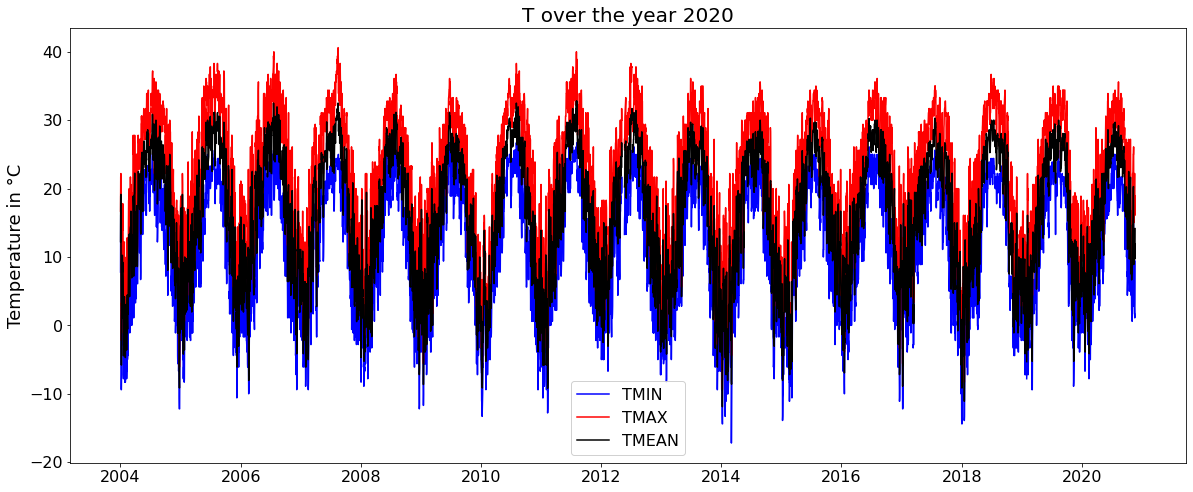

In [15]:
fig, ax = plt.subplots()
ax.plot(d[mask].TMIN, color="b", label="TMIN")
ax.plot(d[mask].TMAX, color="r", label="TMAX")
ax.plot(d[mask].TMEAN, color="k", label="TMEAN")
ax.set_title("T over the year 2020")
ax.set_ylabel("Temperature in °C")
ax.legend()

In [17]:
pathlist = Path("ghcnd_hcn").rglob('*.dly')

In [26]:
testing = []
for i, path in enumerate(pathlist):
    print(str(path))
    testing.append(str(path))
    if i > 5:
        break

ghcnd_hcn\USC00024645.dly
ghcnd_hcn\USC00024849.dly
ghcnd_hcn\USC00025512.dly
ghcnd_hcn\USC00026250.dly
ghcnd_hcn\USC00026353.dly
ghcnd_hcn\USC00026796.dly
ghcnd_hcn\USC00027281.dly


In [35]:
import re
find = re.search("(\w{11}).dly", testing[1])
find.group(1)


'USC00024849'

In [36]:
d.index

DatetimeIndex(['1884-04-01', '1884-04-02', '1884-04-03', '1884-04-04',
               '1884-04-05', '1884-04-06', '1884-04-07', '1884-04-08',
               '1884-04-09', '1884-04-10',
               ...
               '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
               '2020-11-13', '2020-11-16', '2020-11-17', '2020-11-18',
               '2020-11-19', '2020-11-20'],
              dtype='datetime64[ns]', length=48020, freq=None)